# LSTM text classification
Train a simple LSTM on the synthetic binary labels.

In [1]:
import os
from pathlib import Path
import time
from collections import Counter

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


In [2]:
# Hyperparameters
DATA_PATH = Path('../data/synthetic_normal_2_labeled.csv')
TEST_SIZE = 0.2
VAL_SIZE = 0.1
BATCH_SIZE = 64
EPOCHS = 30
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_LEN = 64
MIN_FREQ = 2
MAX_VOCAB = 20000
LEARNING_RATE = 1e-3
PATIENCE = 4
SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}')


Using device: cuda


In [3]:
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [4]:
if not DATA_PATH.exists():
    raise FileNotFoundError(f'Missing dataset at {DATA_PATH}')

df = pd.read_csv(DATA_PATH)
df['sentence'] = df['sentence'].astype(str)
df['label'] = df['label'].astype(int)
print(df['label'].value_counts(normalize=True))


label
1    0.500008
0    0.499992
Name: proportion, dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df['sentence'], df['label'], test_size=TEST_SIZE, random_state=SEED, stratify=df['label']
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VAL_SIZE, random_state=SEED, stratify=y_train
)
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')


Train: 45968, Val: 5108, Test: 12769


In [6]:
def tokenize(text):
    return text.lower().split()

counter = Counter()
for sent in X_train:
    counter.update(tokenize(sent))

stoi = {'<pad>': 0, '<unk>': 1}
for token, freq in counter.most_common(MAX_VOCAB):
    if freq < MIN_FREQ:
        continue
    if token not in stoi:
        stoi[token] = len(stoi)
PAD_IDX = stoi['<pad>']
UNK_IDX = stoi['<unk>']
VOCAB_SIZE = len(stoi)
print(f'Vocab size: {VOCAB_SIZE}')


Vocab size: 20002


In [7]:
def encode_sentence(text, max_len=MAX_LEN):
    tokens = tokenize(text)
    ids = [stoi.get(tok, UNK_IDX) for tok in tokens[:max_len]]
    if len(ids) < max_len:
        ids += [PAD_IDX] * (max_len - len(ids))
    return torch.tensor(ids, dtype=torch.long)

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = list(texts)
        self.labels = list(map(int, labels))
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': encode_sentence(self.texts[idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        direction_mult = 2 if bidirectional else 1
        self.classifier = nn.Linear(hidden_dim * direction_mult, 1)

    def forward(self, input_ids):
        emb = self.embedding(input_ids)
        _, (h_n, _) = self.lstm(emb)
        if self.lstm.bidirectional:
            h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)
        else:
            h_final = h_n[-1]
        logits = self.classifier(self.dropout(h_final))
        return logits.squeeze(-1)

model = LSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_LAYERS, BIDIRECTIONAL, DROPOUT).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print(model)


LSTMClassifier(
  (embedding): Embedding(20002, 128, padding_idx=0)
  (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)


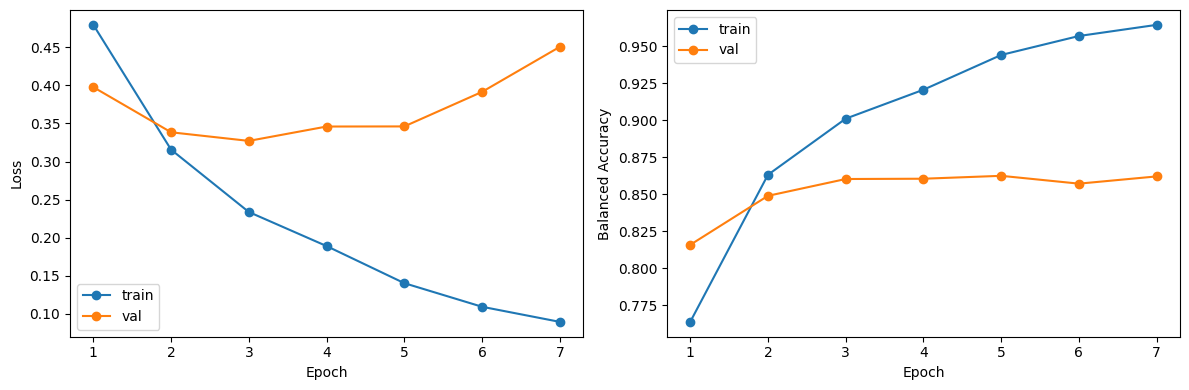

Epoch 7/30 - train_loss 0.0892 train_bal 0.965 val_loss 0.4508 val_bal 0.862
Early stopping at epoch 7 (patience=4)
Best val acc reached after 0.27 min (val_acc=0.863)


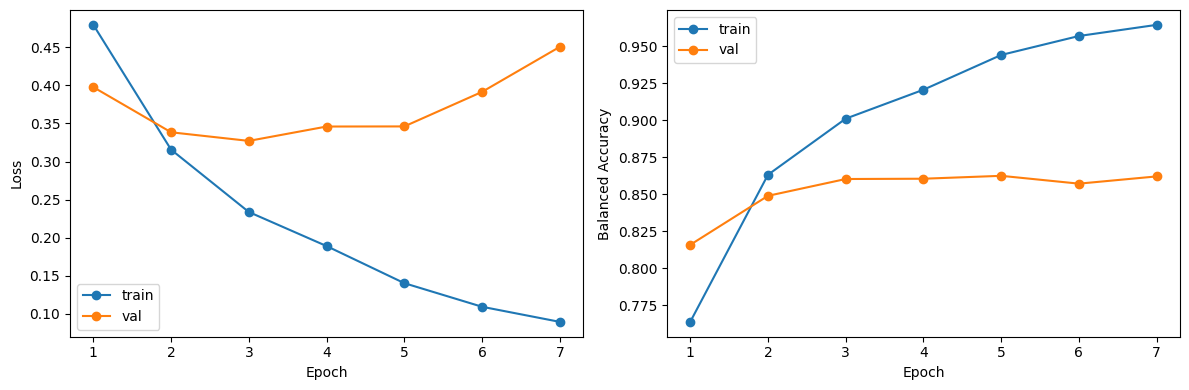

In [9]:
def run_epoch(model, dataloader, train=True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    total_count = 0
    all_preds, all_labels = [], []
    context = torch.enable_grad() if train else torch.no_grad()
    with context:
        for batch in dataloader:
            input_ids = batch['input_ids'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            logits = model(input_ids)
            loss = criterion(logits, labels)
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_count += batch_size
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).long().cpu()
            all_preds.append(preds)
            all_labels.append(labels.long().cpu())
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    all_preds = torch.cat(all_preds) if all_preds else torch.tensor([])
    all_labels = torch.cat(all_labels) if all_labels else torch.tensor([], dtype=torch.long)
    avg_loss = total_loss / total_count if total_count else 0.0
    acc = accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    bal_acc = balanced_accuracy_score(all_labels, all_preds) if len(all_labels) else 0.0
    return avg_loss, acc, bal_acc, all_preds, all_labels

train_loss_hist, val_loss_hist = [], []
train_bal_hist, val_bal_hist = [], []
best_state, best_val_loss, epochs_no_improve = None, float('inf'), 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train_start = time.perf_counter()
best_val_acc = -float('inf')
best_acc_time = None


def plot_live(epochs_ran):
    axes[0].clear(); axes[1].clear()
    axes[0].plot(epochs_ran, train_loss_hist, marker='o', label='train')
    axes[0].plot(epochs_ran, val_loss_hist, marker='o', label='val')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].legend()
    axes[1].plot(epochs_ran, train_bal_hist, marker='o', label='train')
    axes[1].plot(epochs_ran, val_bal_hist, marker='o', label='val')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Balanced Accuracy'); axes[1].legend()
    plt.tight_layout();
    clear_output(wait=True); display(fig)

for epoch in range(EPOCHS):
    train_loss, train_acc, train_bal, _, _ = run_epoch(model, train_loader, train=True)
    val_loss, val_acc, val_bal, _, _ = run_epoch(model, val_loader, train=False)
    train_loss_hist.append(train_loss); val_loss_hist.append(val_loss)
    train_bal_hist.append(train_bal); val_bal_hist.append(val_bal)

    if val_acc > best_val_acc + 1e-6:
        best_val_acc = val_acc
        best_acc_time = time.perf_counter() - train_start

    improved = val_loss + 1e-4 < best_val_loss
    if improved:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    else:
        epochs_no_improve += 1
    plot_live(range(1, len(train_loss_hist) + 1))
    print(
        f'Epoch {epoch + 1}/{EPOCHS} - train_loss {train_loss:.4f} '
        f'train_bal {train_bal:.3f} val_loss {val_loss:.4f} val_bal {val_bal:.3f}'
    )
    if epochs_no_improve >= PATIENCE:
        print(f'Early stopping at epoch {epoch + 1} (patience={PATIENCE})')
        break
if best_state is not None:
    model.load_state_dict(best_state)

if best_acc_time is not None:
    print(f"Best val acc reached after {best_acc_time/60:.2f} min (val_acc={best_val_acc:.3f})")



In [10]:
test_loss, test_acc, test_bal, test_preds, test_labels = run_epoch(model, test_loader, train=False)
print(f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.3f}, Balanced acc: {test_bal:.3f}')
print('Classification report:')
print(classification_report(test_labels.numpy(), test_preds.numpy(), digits=3))


Test loss: 0.3160, Test acc: 0.863, Balanced acc: 0.863
Classification report:
              precision    recall  f1-score   support

           0      0.853     0.878     0.865      6384
           1      0.874     0.849     0.861      6385

    accuracy                          0.863     12769
   macro avg      0.864     0.863     0.863     12769
weighted avg      0.864     0.863     0.863     12769

